In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import functools, operator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/data.csv')
df

,VideoID,Description
0,-4wsuPCjDBc_5_15,a squirrel is eating a peanut in it s shell
1,-4wsuPCjDBc_5_15,a chipmunk is eating
2,-4wsuPCjDBc_5_15,a chipmunk is eating a peanut
3,-4wsuPCjDBc_5_15,a chipmunk is eating a nut
4,-4wsuPCjDBc_5_15,a squirrel is eating a nut
...,...,...
80783,zxB4dFJhHR8_1_9,a girl riding a bicycle
80784,zxB4dFJhHR8_1_9,a smiling girl wearing backpack is riding a bike
80785,zxB4dFJhHR8_1_9,the girl rode her bike at the beach
80786,zzit5b_-ukg_5_20,a boy is doing exercise by cycle


In [ ]:
videoIDs = list(df.VideoID.unique())
print(len(videoIDs))

1970


In [ ]:
#Prepare training and validation data
df = pd.read_csv('/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/data.csv')
train_ids = videoIDs[:1870]
train_split = 0.85
train_list=[]
vocab_list=[]
for i in range(len(train_ids)):
  df_temp=df.loc[df['VideoID']==train_ids[i]]
  for _, row in df_temp.iterrows():
    caption = "<bos> " + row['Description'] + " <eos>"
    if len(caption.split()) > 10 or len(caption.split()) < 6:
        continue
    else:
        train_list.append([caption, train_ids[i]])
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]

for train in training_list:
    vocab_list.append(train[0])
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)

In [ ]:
x_data_global={}
for i,id in enumerate(train_ids):
  feat_path = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/global_features/'+id+'.npy'
  features=np.load(feat_path)
  x_data_global[id]=features
print(len(x_data_global))

1870


In [ ]:
x_data_motion={}
for i,id in enumerate(train_ids):
  feat_path = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/'+id+'.npy'
  features=np.load(feat_path)
  x_data_motion[id]=features
print(len(x_data_motion))

1870


In [ ]:
x_data_local={}
for i,id in enumerate(train_ids):
  feat_path = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/local_features1/'+id+'.npy'
  features=np.load(feat_path)
  x_data_local[id]=features
print(len(x_data_local))

1870


In [ ]:
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Hyperparameters
time_steps_encoder=28
num_encoder_tokens=2048
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320
epochs = 25
save_model_path = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/saved model gru gauss'

#Data generator for loading data in batches while training
def load_dataset(training_list):
  encoder_input_data_global = []
  encoder_input_data_motion = []
  encoder_input_data_local = []
  decoder_input_data = []
  decoder_target_data = []
  train_videoIDs = []
  videoSeq = []
  for idx, cap in enumerate(training_list):
    caption = cap[0]
    train_videoIDs.append(cap[1])
    videoSeq.append(caption)
  train_sequences = tokenizer.texts_to_sequences(videoSeq)
  train_sequences = np.array(train_sequences)
  train_sequences = pad_sequences(train_sequences, padding='post', truncating='post',
                                  maxlen=10)
  file_size = len(train_sequences)
  n = 0
  for i in range(epochs): #epochs
    for idx in range(0, file_size):
      n += 1
      encoder_input_data_global.append(x_data_global[train_videoIDs[idx]])
      encoder_input_data_motion.append(x_data_motion[train_videoIDs[idx]])
      encoder_input_data_local.append(x_data_local[train_videoIDs[idx]])
      y = tf.keras.utils.to_categorical(train_sequences[idx], 1500)
      decoder_input_data.append(y[:-1])
      decoder_target_data.append(y[1:])
      if n == batch_size: #batch size
        encoder_input_global = np.array(encoder_input_data_global)
        encoder_input_motion = np.array(encoder_input_data_motion)
        encoder_input_local = np.array(encoder_input_data_local)
        decoder_input = np.array(decoder_input_data)
        decoder_target = np.array(decoder_target_data)
        encoder_input_data_global = []
        encoder_input_data_motion = []
        encoder_input_data_local = []
        decoder_input_data = []
        decoder_target_data = []
        n = 0
        yield ([encoder_input_global, encoder_input_motion, encoder_input_local, decoder_input], decoder_target)

In [ ]:
import tensorflow as tf

class GaussianAttention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(GaussianAttention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(GaussianAttention, self).build(input_shape)

    def call(self, x):
        e = tf.matmul(x, self.W) + self.b
        a = tf.nn.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)

In [ ]:
# Model training
def train_model():
  encoder_inputs_global = tf.keras.layers.Input(shape=(time_steps_encoder, 2048), name="encoder_inputs_global")
  encoder_inputs_motion = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_motion")
  encoder_inputs_local = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_local")

  encoder_inputs = tf.keras.layers.Concatenate(axis=2)([encoder_inputs_global, encoder_inputs_motion, encoder_inputs_local])

  encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm1')
  encoder_seq_output, state_h, state_c = encoder(encoder_inputs)

  attention_output = GaussianAttention(return_sequences=True, name='attention')(encoder_seq_output)

  encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm2')
  _, state_h_1, state_c_1 = encoder(attention_output)
  encoder_states = [state_h_1,state_c_1]

  # encoder_states = [state_h]

  decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
  decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
  decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_outputs)
  decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
  decoder_outputs = decoder_dense(decoder_outputs)

  model = tf.keras.models.Model([encoder_inputs_global,encoder_inputs_motion, encoder_inputs_local, decoder_inputs], decoder_outputs)
  # model.summary()
  # training_list, validation_list = preprocessing()

  train = load_dataset(training_list)
  valid = load_dataset(validation_list)

  # early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')

  # Run training
  opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.1, patience=5, verbose=1,
                                                mode="auto")
  model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

  validation_steps = len(validation_list)//batch_size
  steps_per_epoch = len(training_list)//batch_size

  history=model.fit(train, validation_data=valid, validation_steps=validation_steps,
            epochs=epochs, steps_per_epoch=steps_per_epoch,
            callbacks=[reduce_lr])

  if not os.path.exists(save_model_path):
      os.makedirs(save_model_path)

  encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
  decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
  decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, state_h, state_c = decoder_lstm(
      decoder_inputs, initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = tf.keras.models.Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)
  # encoder_model.summary()
  # decoder_model.summary()

  # saving the models
  encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
  decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
  with open(os.path.join(save_model_path, 'tokenizer' + str(num_decoder_tokens)), 'wb') as file:
      joblib.dump(tokenizer, file)

  return history

history = train_model()

Epoch 1/25
152/152 [==============================] - 142s 843ms/step - loss: 3.5812 - accuracy: 0.4026 - val_loss: 3.0389 - val_accuracy: 0.4478 - lr: 3.0000e-04
Epoch 2/25
152/152 [==============================] - 125s 825ms/step - loss: 2.9988 - accuracy: 0.4664 - val_loss: 2.8821 - val_accuracy: 0.5222 - lr: 3.0000e-04
Epoch 3/25
152/152 [==============================] - 128s 842ms/step - loss: 2.8459 - accuracy: 0.5156 - val_loss: 2.7484 - val_accuracy: 0.5394 - lr: 3.0000e-04
Epoch 4/25
152/152 [==============================] - 128s 842ms/step - loss: 2.7170 - accuracy: 0.5394 - val_loss: 2.6300 - val_accuracy: 0.5525 - lr: 3.0000e-04
Epoch 5/25
152/152 [==============================] - 127s 840ms/step - loss: 2.5926 - accuracy: 0.5564 - val_loss: 2.4970 - val_accuracy: 0.5657 - lr: 3.0000e-04
Epoch 6/25
152/152 [==============================] - 128s 841ms/step - loss: 2.4514 - accuracy: 0.5685 - val_loss: 2.3571 - val_accuracy: 0.5731 - lr: 3.0000e-04
Epoch 7/25
152/152 [==

In [ ]:
!pip install numpy==1.21.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.11 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.6 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


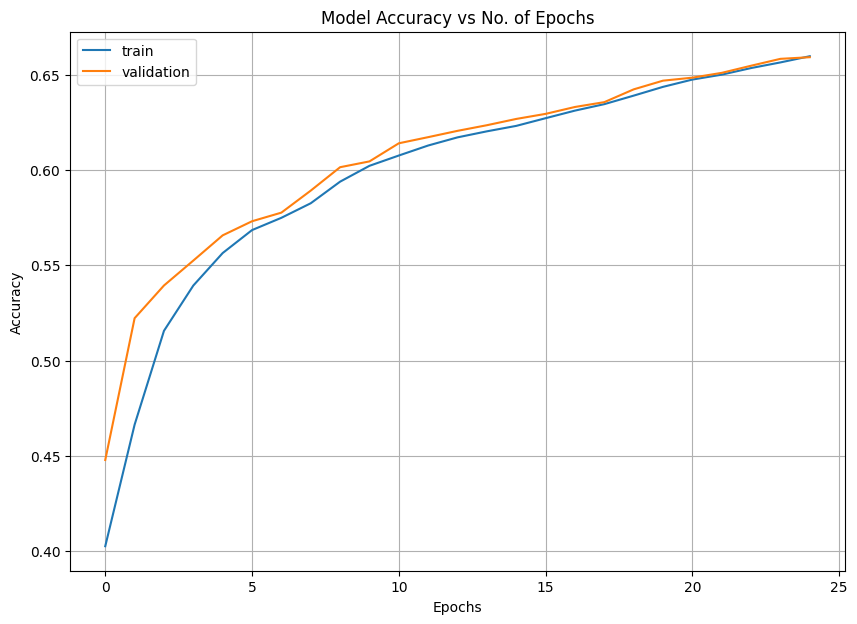

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs No. of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

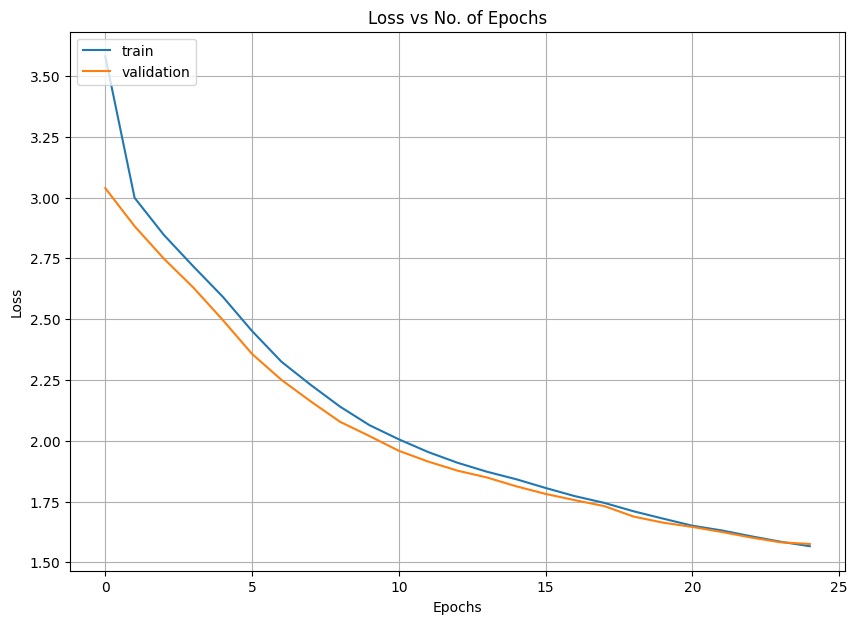

In [ ]:
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs No. of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
file = open('testing_id.txt','w')
for id in videoIDs[-100:]:
  print(id,file=file)
file.close()

In [ ]:
# class to perform inference on all test files and save as test_output.txt
class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 2048
        self.num_decoder_tokens = 1500
        self.time_steps_encoder = 28
        self.time_steps_decoder = None
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/saved model gru gauss'
        self.test_path_global = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/global_features'
        self.test_path_motion = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/motion_features1'
        self.test_path_local = '/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/local_features1'

    def load_inference_models(self):
        # load tokenizer
        with open(os.path.join(self.save_model_path, 'tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = tf.keras.models.load_model(os.path.join(self.save_model_path, 'encoder_model.h5'),custom_objects={'GaussianAttention':GaussianAttention})

        # inference decoder model
        decoder_inputs = tf.keras.layers.Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = tf.keras.layers.Dense(self.num_decoder_tokens, activation='softmax')

        decoder_lstm = tf.keras.layers.LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = tf.keras.layers.Input(shape=(self.latent_dim,))
        decoder_state_input_c = tf.keras.layers.Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = tf.keras.models.Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)

        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, 'decoder_model_weights.h5'))
        print('Loaded Inference Model')


    def index_to_word(self):
        # inverts word tokenizer
        index_to_word = {value: key for key, value in self.tokenizer.word_index.items()}
        return index_to_word

    def greedy_search(self, f):
        """
        :param f: the loaded numpy array after creating videos to frames and extracting features
        :return: the final sentence which has been predicted greedily
        """
        inv_map = self.index_to_word()
        states_value = self.inf_encoder_model.predict(f.reshape(-1, 28, 10240))
        # states_value = np.array(states_value).reshape((1, 512))
        target_seq = np.zeros((1, 1, 1500))
        sentence = ''
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        for i in range(15):
            output_tokens, h, c = self.inf_decoder_model.predict([target_seq] + [states_value])
            states_value = [h, c]
            output_tokens = output_tokens.reshape(self.num_decoder_tokens)
            y_hat = np.argmax(output_tokens)
            if y_hat == 0:
                continue
            if inv_map[y_hat] is None:
                break
            else:
                sentence = sentence + inv_map[y_hat] + ' '
                target_seq = np.zeros((1, 1, 1500))
                target_seq[0, 0, y_hat] = 1
        return ' '.join(sentence.split()[:-1])

    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 10
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path_global, path_motion, path_local):
        X_test = []
        X_test_filename = []
        with open('testing_id.txt') as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                f1 = np.load(os.path.join(path_global , filename + '.npy'))
                f2 = np.load(os.path.join(path_motion , filename + '.npy'))
                f3 = np.load(os.path.join(path_local , filename + '.npy'))
                X_test.append(np.concatenate((f1,f2,f3),axis=1))
                X_test_filename.append(filename)
            X_test = np.array(X_test)
            print('X_test.shape:',X_test.shape)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path_global),os.path.join(self.test_path_motion),os.path.join(self.test_path_local))
        print(len(X_test), len(X_test_filename))
        # generate inference test outputs
        with open(os.path.join(self.save_model_path, 'test_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test):
                file.write(X_test_filename[idx]+',')
                # decoded_sentence = self.decode_sequence2bs(x.reshape(-1, 28, 10240))
                # decode_str = self.decoded_sentence_tuning(decoded_sentence)
                # for d in decode_str:
                #     file.write(d + ' ')

                decoded_sentence = self.greedy_search(x.reshape(-1, 28, 10240))
                file.write(decoded_sentence)

                file.write('\n')
                # re-init max prob
                self.max_probability = -1

In [ ]:
c = Video2Text()
c.load_inference_models()
c.test()

Loaded Inference Model
X_test.shape: (100, 28, 10240)
100 100
1/1 [==============================] - 0s 33ms/step


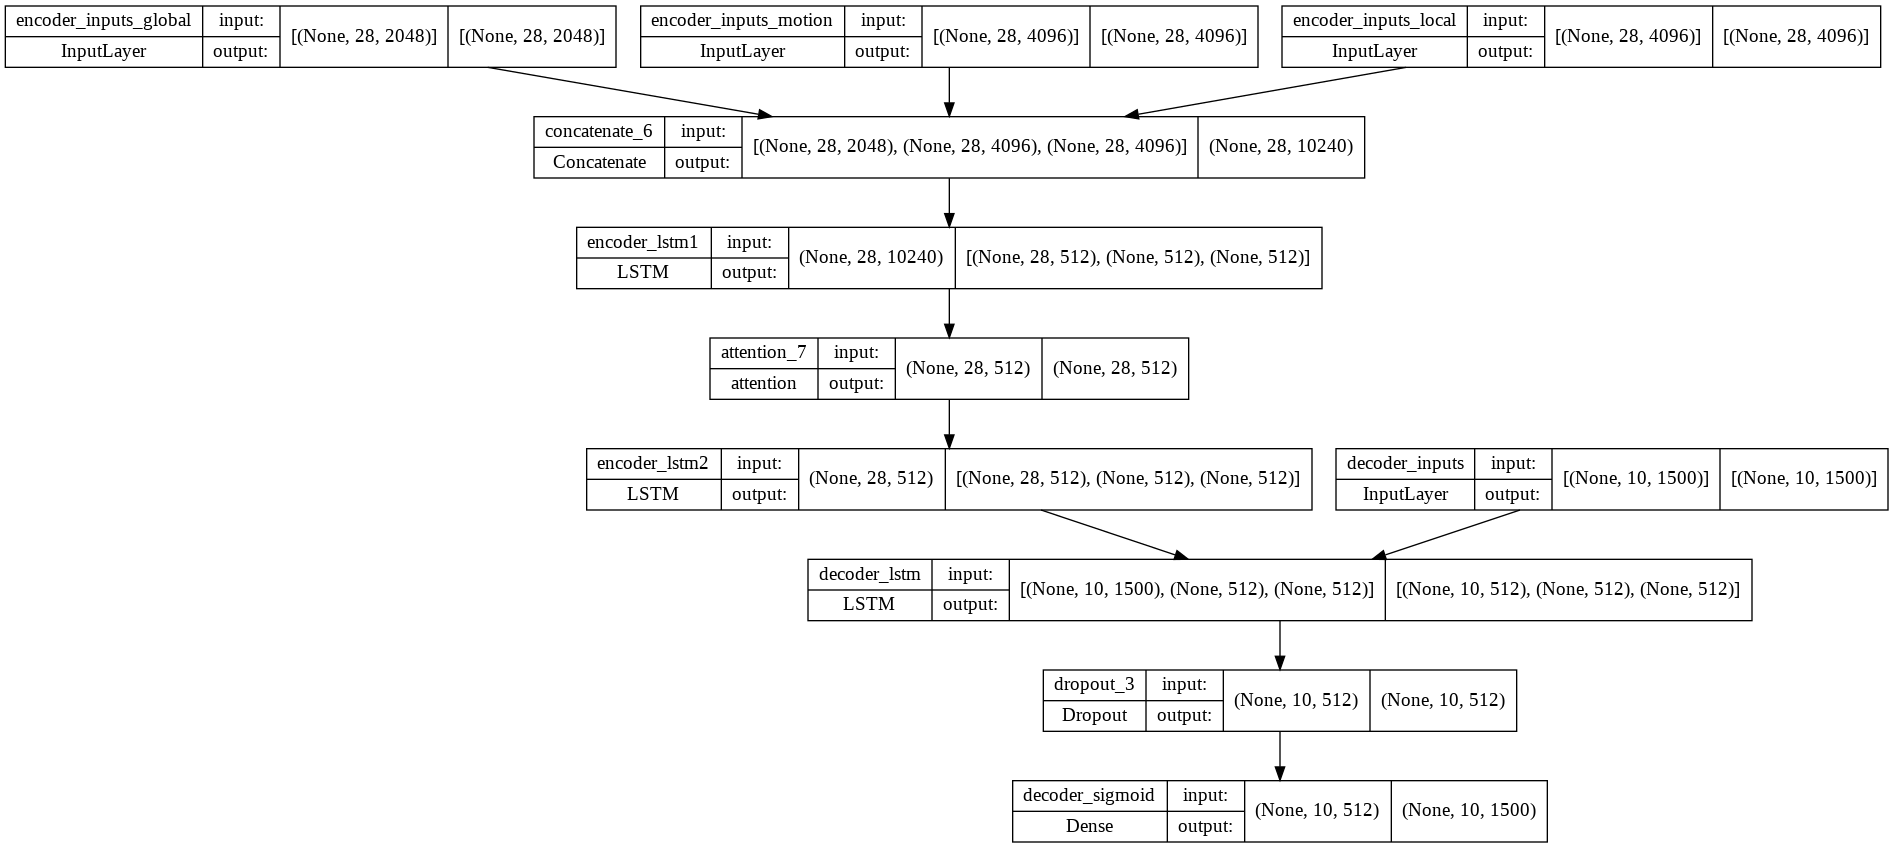

In [ ]:
from keras.utils.vis_utils import plot_model
encoder_inputs_global = tf.keras.layers.Input(shape=(time_steps_encoder, 2048), name="encoder_inputs_global")
encoder_inputs_motion = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_motion")
encoder_inputs_local = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_local")

encoder_inputs = tf.keras.layers.Concatenate(axis=2)([encoder_inputs_global, encoder_inputs_motion, encoder_inputs_local])

encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm1')
encoder_seq_output, state_h, state_c = encoder(encoder_inputs)

attention_output = attention(return_sequences=True, name='attention')(encoder_seq_output)

encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm2')
_, state_h_1, state_c_1 = encoder(attention_output)
encoder_states = [state_h_1,state_c_1]

# encoder_states = [state_h]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_outputs)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs_global,encoder_inputs_motion, encoder_inputs_local, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Prepare training and validation data
df = pd.read_csv('/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/data.csv')
test_ids = videoIDs[-100:]

references_list=[]
ref_dict={'annotations':[]}
for i in range(len(test_ids)):
  df_temp=df.loc[df['VideoID']==test_ids[i]]
  references=[]
  for _, row in df_temp.iterrows():
    reference = row['Description'].split()
    ref_dict['annotations'].append({u'video_id':i,u'caption':row['Description']})
    references.append(reference)
  references_list.append(references)

print(ref_dict)

{'annotations': [{'video_id': 0, 'caption': 'a man skates a tunnel then falls'}, {'video_id': 0, 'caption': 'a guy hurts himself from falling off his skateboard'}, {'video_id': 0, 'caption': 'a guy is falling off a skateboard'}, {'video_id': 0, 'caption': 'a guy is riding a skateboard on a ramp and falls to the ground'}, {'video_id': 0, 'caption': 'a man is falling when he performs skating stunts'}, {'video_id': 0, 'caption': 'a man is skateboarding and falls'}, {'video_id': 0, 'caption': 'a man is skateboarding'}, {'video_id': 0, 'caption': 'a man with a bruise on his lower back rides a skateboard up a slope'}, {'video_id': 0, 'caption': 'a skatboarder falls down'}, {'video_id': 0, 'caption': 'a skateboarder crashes to the ground'}, {'video_id': 0, 'caption': 'a skateboarder is falling while trying to perform tricks'}, {'video_id': 0, 'caption': 'a skateboarder misses his landing and crashes'}, {'video_id': 0, 'caption': 'the man fell off his skateboard'}, {'video_id': 0, 'caption': '

In [ ]:
hypotheses = []
count=0
hyp_dict={'annotations':[]}
with open('/content/drive/MyDrive/VIDEO CAPTIONING/video captioning/saved model gru gauss/test_output.txt','r') as file:
  for line in file:
    vid = line.split(',')[0]
    hyp = line.split(',')[1]
    hyp=hyp.split('\n')[0]
    hypotheses.append(hyp)
    hyp_dict['annotations'].append({u'video_id':count,u'caption':hyp})
    count=count+1

print(hyp_dict)

{'annotations': [{'video_id': 0, 'caption': 'a man is running'}, {'video_id': 1, 'caption': 'a man is shooting a gun'}, {'video_id': 2, 'caption': 'a man is dancing'}, {'video_id': 3, 'caption': 'a dog is playing with a ball'}, {'video_id': 4, 'caption': 'a baby is eating'}, {'video_id': 5, 'caption': 'a woman is slicing a potato'}, {'video_id': 6, 'caption': 'a man is shooting a gun'}, {'video_id': 7, 'caption': 'a cat is playing with a toy'}, {'video_id': 8, 'caption': 'a man is lifting a'}, {'video_id': 9, 'caption': 'a baby is laughing'}, {'video_id': 10, 'caption': 'a man is doing exercise'}, {'video_id': 11, 'caption': 'a woman is dancing'}, {'video_id': 12, 'caption': 'a man is cutting a'}, {'video_id': 13, 'caption': 'a man is shooting a gun'}, {'video_id': 14, 'caption': 'a man is running'}, {'video_id': 15, 'caption': 'a monkey is walking'}, {'video_id': 16, 'caption': 'a car is running'}, {'video_id': 17, 'caption': 'a man is riding a bike'}, {'video_id': 18, 'caption': 'a m

In [ ]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-i1ag_8_t
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-i1ag_8_t
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312249 sha256=141b464349a67b06df4cd735280eeb2beebbcb66497ec4b805f0988fe5e962e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-vkmgu3kv/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'video_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['video_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["video_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

def calculate_metrics(rng,datasetGTS,datasetRES):
    imgIds = rng
    gts = {}
    res = {}

    imgToAnnsGTS = {ann['video_id']: [] for ann in datasetGTS['annotations']}
    for ann in datasetGTS['annotations']:
        imgToAnnsGTS[ann['video_id']] += [ann]

    imgToAnnsRES = {ann['video_id']: [] for ann in datasetRES['annotations']}
    for ann in datasetRES['annotations']:
        imgToAnnsRES[ann['video_id']] += [ann]

    for imgId in imgIds:
        gts[imgId] = imgToAnnsGTS[imgId]
        res[imgId] = imgToAnnsRES[imgId]

    evalObj = COCOEvalCap(imgIds,gts,res)
    evalObj.evaluate()
    return evalObj.eval

rng = range(100)
print(calculate_metrics(rng,ref_dict,hyp_dict))

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 535, 'reflen': 534, 'guess': [535, 435, 335, 235], 'correct': [343, 130, 63, 22]}
ratio: 1.0018726591741538
Bleu_1: 0.641
Bleu_2: 0.438
Bleu_3: 0.330
Bleu_4: 0.241
computing METEOR score...
METEOR: 0.206
computing Rouge score...
ROUGE_L: 0.568
computing CIDEr score...
CIDEr: 0.302
{'Bleu_1': 0.6411214953259045, 'Bleu_2': 0.43772083265288575, 'Bleu_3': 0.33029098887307234, 'Bleu_4': 0.24099678480260878, 'METEOR': 0.20649075790382074, 'ROUGE_L': 0.5680150465835776, 'CIDEr': 0.30162591839899966}
